In [2]:
import torch
import lightning
import os
from matplotlib import pyplot as plt
import SimpleITK as sitk
import numpy as np
import pickle
import torchio as tio
from monai import transforms
import monai


In [ ]:
transforms.SaveImage

In [3]:
gt_path = '/Users/ikboljon.sobirov/Documents/aorta/adiporedox_orig/R277/R277_gt.nrrd'
gt = sitk.ReadImage(gt_path)
gt = sitk.GetArrayFromImage(gt)


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/Users/ikboljon.sobirov/Documents/aorta/adiporedox_orig/R277/R277_gt.nrrd" does not exist.

In [2]:
path = '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/'
# path_resized = '/home/ikboljonsobirov/sega/segaorta_tensor/'

# if not os.path.exists(path_resized):
#     os.makedirs(path_resized)

# pickle_path = '/home/ikboljonsobirov/sega/segaorta_pickle/'
# if not os.path.exists(pickle_path):
#     os.makedirs(pickle_path)

In [3]:
patitents = os.listdir(path)
len(patitents)

525

In [11]:
patitents[0]

'HGJ-082'

In [28]:
ct = sitk.ReadImage(os.path.join(path, 'CHUV-008', 'CHUV-008_ct.nii.gz'))
pt = sitk.ReadImage(os.path.join(path,'CHUV-008', 'CHUV-008_pt.nii.gz'))
gt = sitk.ReadImage(os.path.join(path, 'CHUV-008', 'CHUV-008_gt.nii.gz'))

In [29]:
ct_data = sitk.GetArrayFromImage(ct)
pt_data = sitk.GetArrayFromImage(pt)
gt_data = sitk.GetArrayFromImage(gt)
ct_data.shape, pt_data.shape, gt_data.shape

((310, 200, 200), (310, 200, 200), (310, 200, 200))

In [30]:
np.unique(gt_data)

array([0, 1], dtype=uint8)

In [18]:
gt_tum = gt_data.copy()
gt_tum[gt_tum == 2] = 0

gt_nod = gt_data.copy()
gt_nod[gt_nod == 1] = 0
# gt_nod[gt_nod == 2] = 1

gt_new = np.stack([gt_nod, gt_tum], axis=0)

In [19]:
np.unique(gt_new)

array([0, 1, 2], dtype=uint8)

In [20]:
gt_new.shape

(2, 295, 200, 200)

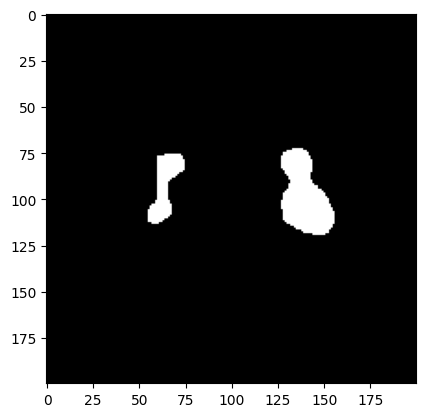

In [27]:
plt.imshow(gt_new[0, 100, :, :], cmap='gray')

In [3]:
class Resizing:
    def __init__(self, mode='train', z=196, x=196, y=196):
        if mode not in ['train', 'test']:
            raise ValueError(f"Argument 'mode' must be 'train' or 'test'. Received {mode}")

        self.mode = mode
        self.z = z
        self.x = x
        self.y = y

    def __call__(self, sample):
        if self.mode == 'train':
            img, mask = sample['input'], sample['target']
            img = tio.Resize((self.z, self.x, self.y), image_interpolation='bspline')(img)
            mask = tio.Resize((self.z, self.x, self.y), image_interpolation='nearest')(mask)
            mask = torch.where(mask == 1., 1., 0.)
            sample['input'], sample['target'] = img, mask
        else:
            img = sample['input']
            img = tio.Resize((self.z, self.x, self.y), image_interpolation='bspline')(img)
            sample['input'] = img
        return sample 

In [4]:
patients = os.listdir(path)
len(patients)

56

In [13]:
for p in patients:
    patient_path_ct = os.path.join(path, p, (p+'_ct.nrrd'))
    patient_path_gt = os.path.join(path, p, (p+'_gt.seg.nrrd'))

    pat_ct_ = sitk.GetArrayFromImage(sitk.ReadImage(patient_path_ct))
    pat_gt_ = sitk.GetArrayFromImage(sitk.ReadImage(patient_path_gt))
    
    pat_c = pat_ct_.astype(np.int16)
    pat_g = pat_gt_.astype(np.int16)
    
    # break
    pat_ct = torch.from_numpy(pat_c)
    pat_ct = pat_ct.unsqueeze(0) 
    
    pat_gt = torch.from_numpy(pat_g)
    pat_gt = pat_gt.unsqueeze(0)

    # print(pat_ct.shape)
    # break
    normalizer = transforms.NormalizeIntensity(channel_wise=True)
    ct_transformed = normalizer(pat_ct)
    
    # break

    # transform = Resizing(z=768,x=384,y=384)
    sample = dict()

    sample['input'] = ct_transformed
    sample['target'] = pat_gt

    
    if not os.path.exists(os.path.join(path_resized, p)):
        os.makedirs(os.path.join(path_resized, p))

    print(p, sample['input'].shape)
    torch.save(sample['input'], os.path.join(path_resized, p, (p+'_ct.pt')))
    torch.save(sample['target'], os.path.join(path_resized, p, (p+'_gt.pt')))


    # break

torch.Size([1, 530, 415, 415])
K1 torch.Size([1, 530, 415, 415])
torch.Size([1, 710, 438, 438])
K14 torch.Size([1, 710, 438, 438])
torch.Size([1, 297, 224, 224])
K19 torch.Size([1, 297, 224, 224])
torch.Size([1, 681, 418, 418])
K8 torch.Size([1, 681, 418, 418])
torch.Size([1, 635, 384, 384])
R13 torch.Size([1, 635, 384, 384])
torch.Size([1, 470, 282, 282])
K20 torch.Size([1, 470, 282, 282])
torch.Size([1, 407, 456, 350])
D12 torch.Size([1, 407, 456, 350])
torch.Size([1, 620, 330, 330])
K17 torch.Size([1, 620, 330, 330])
torch.Size([1, 386, 456, 350])
D16 torch.Size([1, 386, 456, 350])
torch.Size([1, 700, 386, 386])
K12 torch.Size([1, 700, 386, 386])
torch.Size([1, 895, 701, 701])
R16 torch.Size([1, 895, 701, 701])
torch.Size([1, 630, 382, 382])
R9 torch.Size([1, 630, 382, 382])
torch.Size([1, 419, 437, 336])
D13 torch.Size([1, 419, 437, 336])
torch.Size([1, 885, 545, 545])
R15 torch.Size([1, 885, 545, 545])
torch.Size([1, 673, 375, 375])
K6 torch.Size([1, 673, 375, 375])
torch.Size([1,

In [40]:
a = torch.load('/home/ikboljonsobirov/sega/sega_miccai-1/notebooks/tensor.pt')

In [42]:
a.shape

torch.Size([1, 256, 256, 256])

In [34]:
pat_c.dtype

dtype('int16')

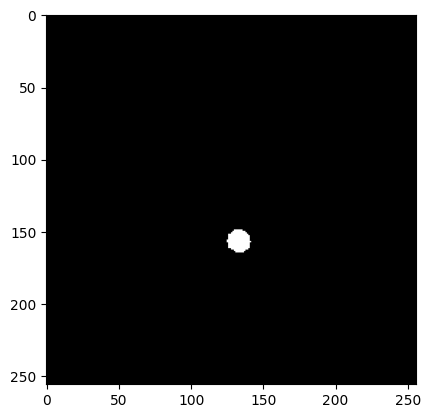

In [38]:
plt.imshow(ct_resized['target'].cpu().detach().numpy()[0, 155, :, :], cmap='gray')

In [27]:
for p in patients:
    patient_path_ct = os.path.join(path, p, (p+'_ct.nrrd'))
    patient_path_gt = os.path.join(path, p, (p+'_gt.seg.nrrd'))

    pat_ct = sitk.GetArrayFromImage(sitk.ReadImage(patient_path_ct))
    pat_gt = sitk.GetArrayFromImage(sitk.ReadImage(patient_path_gt))

    if not os.path.exists(os.path.join(pickle_path, p)):
        os.makedirs(os.path.join(pickle_path, p))

    pickle.dump(pat_ct, open(os.path.join(pickle_path, p, (p+"_ct.pickle")), "wb"), protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(pat_gt, open(os.path.join(pickle_path, p, (p+"_gt.pickle")), "wb"), protocol=pickle.HIGHEST_PROTOCOL)
    print(p, 'is done')
    # break

K1 is done
K14 is done
K19 is done
K8 is done
R13 is done
K20 is done
D12 is done
K17 is done
D16 is done
K12 is done
R16 is done
R9 is done
D13 is done
R15 is done
K6 is done
R6 is done
R7 is done
R11 is done
K3 is done
R17 is done
R5 is done
D18 is done
D1 is done
K5 is done
D11 is done
K15 is done
D14 is done
R18 is done
R3 is done
K9 is done
R1 is done
K4 is done
D8 is done
R2 is done
R14 is done
K7 is done
K11 is done
R8 is done
K16 is done
D4 is done
R10 is done
K2 is done
D15 is done
D5 is done
D3 is done
D17 is done
D6 is done
R4 is done
K18 is done
R12 is done
K13 is done
K10 is done
D2 is done
D10 is done
D9 is done
D7 is done


In [4]:
pat = sitk.ReadImage(os.path.join(path, patients[0], (patients[0]+'_ct.nrrd')))

In [5]:
a = sitk.GetArrayFromImage(pat)

In [6]:
a.shape

(530, 415, 415)

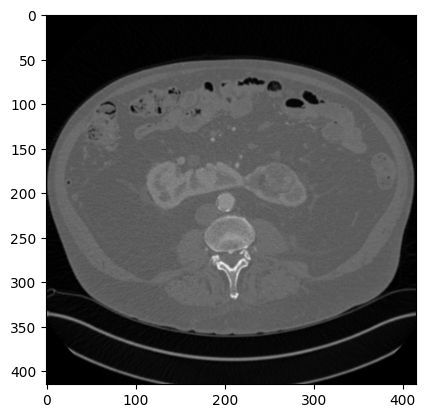

In [7]:
plt.imshow(a[150, :, :], cmap='gray')

In [9]:
with open('/home/ikboljonsobirov/sega/sega_miccai-1/notebooks/test.pkl','wb') as f:
     pickle.dump(a, f)


In [13]:
with open('/home/ikboljonsobirov/sega/sega_miccai-1/notebooks/file_name.pickle','rb') as f:
    x = pickle.load(f)
    print(x.shape)


(530, 415, 415)


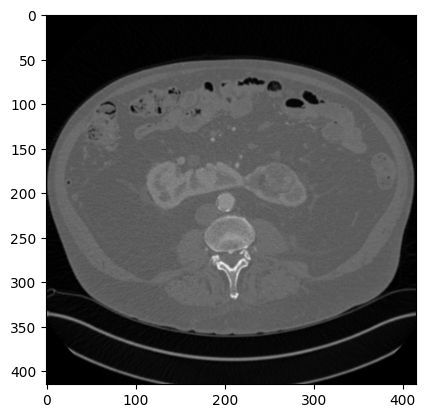

In [14]:
plt.imshow(x[150, :, :], cmap='gray')

In [13]:
np.save('/home/ikboljonsobirov/sega/sega_miccai-1/notebooks/ask_python', a)

In [14]:
data = np.load('/home/ikboljonsobirov/sega/sega_miccai-1/notebooks/ask_python.npy')

In [15]:
data.shape

(530, 415, 415)

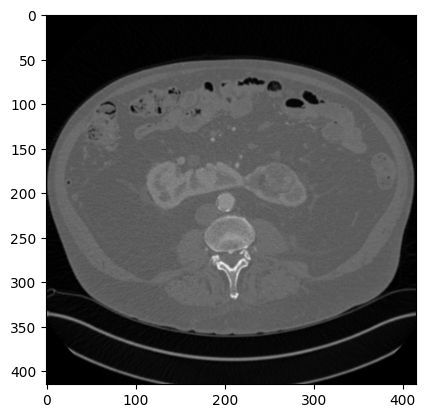

In [16]:
plt.imshow(data[150, :, :], cmap='gray')

### check image and label dimensions

In [3]:
patients = os.listdir(path)
len(patients)

56

In [4]:
findings = {}
findings['id'] = []
findings['z'] = []
findings['x']  = []
findings['y']  = []
findings['z_min'] = []
findings['z_max'] = []
findings['x_min']  = []
findings['x_max'] = []
findings['y_min'] = []
findings['y_max'] = []

In [5]:
for p in patients:
    print('Processing', p)
    patient_path_ct = os.path.join(path, p, (p+'_ct.nrrd'))
    patient_path_gt = os.path.join(path, p, (p+'_gt.seg.nrrd'))

    pat_ct_ = sitk.GetArrayFromImage(sitk.ReadImage(patient_path_ct))
    pat_gt_ = sitk.GetArrayFromImage(sitk.ReadImage(patient_path_gt))

    mask_where = np.where(pat_gt_>0)
    z_min = np.min(mask_where[0])
    z_max = np.max(mask_where[0])
    x_min = np.min(mask_where[1])
    x_max = np.max(mask_where[1])
    y_min = np.min(mask_where[2])
    y_max = np.max(mask_where[2])

    findings['id'].append(p)
    findings['z'].append(pat_ct_.shape[0])
    findings['x'].append(pat_ct_.shape[1])
    findings['y'].append(pat_ct_.shape[2])
    findings['z_min'].append(z_min)
    findings['z_max'].append(z_max)
    findings['x_min'].append(x_min)
    findings['x_max'].append(x_max)
    findings['y_min'].append(y_min)
    findings['y_max'].append(y_max)


    # print(pat_ct_.shape)
    # # break
    # dims['z'].append(pat_ct_.shape[0])
    # dims['x'].append(pat_ct_.shape[1])
    # dims['y'].append(pat_ct_.shape[2])

Processing K1
Processing K14
Processing K19
Processing K8
Processing R13
Processing K20
Processing D12
Processing K17
Processing D16
Processing K12
Processing R16
Processing R9
Processing D13
Processing R15
Processing K6
Processing R6
Processing R7
Processing R11
Processing K3
Processing R17
Processing R5
Processing D18
Processing D1
Processing K5
Processing D11
Processing K15
Processing D14
Processing R18
Processing R3
Processing K9
Processing R1
Processing K4
Processing D8
Processing R2
Processing R14
Processing K7
Processing K11
Processing R8
Processing K16
Processing D4
Processing R10
Processing K2
Processing D15
Processing D5
Processing D3
Processing D17
Processing D6
Processing R4
Processing K18
Processing R12
Processing K13
Processing K10
Processing D2
Processing D10
Processing D9
Processing D7


In [33]:
np.mean(findings['y_max'])

273.05357142857144

In [1]:
csv_path = '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_patient_info_training.csv'
endpoints_path = '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_patient_endpoint_training.csv'

import pandas as pd


In [3]:
patient_info = pd.read_csv(csv_path)
patient_endpoint = pd.read_csv(endpoints_path)
patient_info.head()

EmptyDataError: No columns to parse from file

: 

In [1]:
import multiprocessing

num_cpus = multiprocessing.cpu_count()
print(f"Number of CPUs: {num_cpus}")

Number of CPUs: 128


In [2]:
import multiprocessing
import time

def worker():
    time.sleep(10)

if __name__ == "__main__":
    num_workers = 4
    pool = multiprocessing.Pool(num_workers)
    for i in range(num_workers):
        pool.apply_async(worker)
    pool.close()
    while True:
        active_processes = multiprocessing.active_children()
        num_active_cpus = len(active_processes)
        print(f"Number of active CPUs: {num_active_cpus}")
        time.sleep(1)
        if num_active_cpus == 0:
            break

Number of active CPUs: 4
Number of active CPUs: 4
Number of active CPUs: 4
Number of active CPUs: 4
Number of active CPUs: 4
Number of active CPUs: 4
Number of active CPUs: 4
Number of active CPUs: 4
Number of active CPUs: 4
Number of active CPUs: 4
Number of active CPUs: 4
Number of active CPUs: 0


In [3]:
import psutil
import time

def monitor_system():
    while True:
        cpu_percent = psutil.cpu_percent()
        mem_percent = psutil.virtual_memory().percent
        print(f"CPU usage: {cpu_percent:.2f}%, Memory usage: {mem_percent:.2f}%")
        time.sleep(1)

# Start monitoring the system in a separate thread
import threading
monitor_thread = threading.Thread(target=monitor_system)
monitor_thread.start()

# Your training code goes here
# ...

# Wait for the monitor thread to finish
monitor_thread.join()

CPU usage: 11.80%, Memory usage: 32.70%
CPU usage: 11.00%, Memory usage: 31.70%
CPU usage: 9.30%, Memory usage: 32.40%
CPU usage: 9.60%, Memory usage: 32.50%
CPU usage: 9.50%, Memory usage: 30.70%
CPU usage: 9.40%, Memory usage: 31.60%
CPU usage: 9.80%, Memory usage: 35.50%
CPU usage: 10.30%, Memory usage: 37.90%
CPU usage: 9.00%, Memory usage: 37.60%
CPU usage: 9.30%, Memory usage: 37.80%
CPU usage: 9.20%, Memory usage: 33.20%
CPU usage: 9.90%, Memory usage: 32.70%
CPU usage: 10.10%, Memory usage: 29.70%
CPU usage: 9.60%, Memory usage: 32.00%
CPU usage: 9.50%, Memory usage: 29.30%
CPU usage: 9.30%, Memory usage: 26.30%
CPU usage: 10.50%, Memory usage: 28.20%
CPU usage: 10.30%, Memory usage: 29.80%
CPU usage: 9.20%, Memory usage: 32.20%
CPU usage: 10.00%, Memory usage: 34.70%
CPU usage: 9.50%, Memory usage: 36.00%
CPU usage: 9.40%, Memory usage: 36.80%
CPU usage: 10.60%, Memory usage: 34.00%
CPU usage: 10.40%, Memory usage: 33.50%


KeyboardInterrupt: 

CPU usage: 9.30%, Memory usage: 33.40%
CPU usage: 8.80%, Memory usage: 31.40%
CPU usage: 9.10%, Memory usage: 32.90%
CPU usage: 9.10%, Memory usage: 34.70%
